<a href="https://colab.research.google.com/github/fdac25/trading/blob/main/src/LLM_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
Based on what we have discussed, right now I plan to use FinBERT on scraped data to generate sentiment scores. We can then use this to train the TF-IDF vectorizer to make predictions. I am still refining, but open if there is any misunderstanding on my part.

# Dependencies

In [1]:
# WIP - still converting to fit our application
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

# FinBERT Training

# TF-IDF Vectorizer

In [23]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [24]:
# To remove patterns from the text
def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

In [25]:
# remove names that will not hold sentimental value - stocks for final
names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

In [6]:
# to remove stop words from the text
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

In [26]:
# To tokenize the text
def tokenize(d):
    return word_tokenize(d)

In [27]:
# Applying all the functions
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

,final_text
0,"[dhepburn, said]"
1,"[plus, youve, added, commercials, experience, ..."
2,"[didnt, today, must, mean, need, take, another..."
3,"[really, aggressive, blast, obnoxious, enterta..."
4,"[really, big, bad, thing]"


In [28]:
# Converting tokens to strings
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['final_text'][i] = " ".join(df['final_text'][i])
/tmp/ipython-input-1525613189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_text'][i] = " ".join(df['final_text'][i])
/tmp/ipython-input-1525613189.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a co

In [29]:
# Adding neagtivereason to strings
# Replacing negativereason with title (negativereason was a short description of the tweet the ex. used)

df['final_text_2'] = df['negativereason'].fillna('') + ' ' + df['final_text']
df[['final_text' , 'final_text_2']]

,final_text,final_text_2
0,dhepburn said,dhepburn said
1,plus youve added commercials experience tacky,plus youve added commercials experience tacky
2,didnt today must mean need take another trip,didnt today must mean need take another trip
3,really aggressive blast obnoxious entertainmen...,Bad Flight really aggressive blast obnoxious e...
4,really big bad thing,Can't Tell really big bad thing
...,...,...
14635,thank got different chicago,thank got different chicago
14636,leaving minutes late warnings communication mi...,Customer Service Issue leaving minutes late wa...
14637,please bring blackberry,please bring blackberry
14638,money change dont answer phones suggestions ma...,Customer Service Issue money change dont answe...


In [30]:
# Picking out X and y from the data
X = df.final_text_2
y = df.airline_sentiment

In [31]:
# Splliting the X and y into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2, random_state = 4)

In [32]:
X_train

,final_text_2
7013,lord whyjetblue fleets fleek httptconlzsehnee
6356,thanks reminding upcoming trip florida really...
927,Can't Tell still waiting hear back wallet stol...
12699,Can't Tell backpack need see agent
6332,Bad Flight first cockroaches crawling counter ...
...,...
6017,hi guys good morning
709,thank cheese platter abundance entertainment ...
10679,Late Flight dirty damn plane take hour get pla...
8366,Bad Flight apparently pilot made announcement ...


In [33]:
y_train

,airline_sentiment
7013,neutral
6356,neutral
927,negative
12699,negative
6332,negative
...,...
6017,positive
709,positive
10679,negative
8366,negative


In [34]:
X_test

,final_text_2
6088,inflight entertainment tonight willie nelson ...
13176,Cancelled Flight second put cancelled flightle...
6110,flying chicagolaxphx go spotting lax phx airp...
13284,Can't Tell wrote back saying challenging weekt...
702,im flying st class one leg chicago long china...
...,...
8562,airways corporation registers high short inte...
5706,status stlaus
7065,wow keeping times
405,dollar laxlas fares


In [35]:
y_test

,airline_sentiment
6088,neutral
13176,negative
6110,neutral
13284,negative
702,neutral
...,...
8562,neutral
5706,neutral
7065,positive
405,neutral


In [36]:
# TF-IDF Vectorizer
def tfidf(words):
    tfidf_vectorizer = TfidfVectorizer()
    data_feature = tfidf_vectorizer.fit_transform(words)
    return data_feature, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test.tolist())

In [37]:
# Logistic Regression Model to predict
lr_tfidf = LogisticRegression(random_state=42,solver = 'liblinear')
lr_tfidf.fit(X_train_tfidf, y_train)
y_predicted_lr = lr_tfidf.predict(X_test_tfidf)

In [39]:
# Function to print accuaracy, precision and recall
def score_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted,average= 'macro')
    recall = recall_score(y_test, y_predicted,average='macro')
    f1 = f1_score(y_test, y_predicted,average='macro')
    print("accuracy = %0.3f, precision = %0.3f, recall = %0.3f, f1 = %0.3f" % (accuracy, precision, recall, f1))

In [40]:
score_metrics(y_test, y_predicted_lr)

accuracy = 0.924, precision = 0.888, recall = 0.852, f1 = 0.867


In [41]:
# Function to plot Confusion Matrix
def plot_confusion_matrix(y_test, y_predicted, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True, fmt='.20g')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

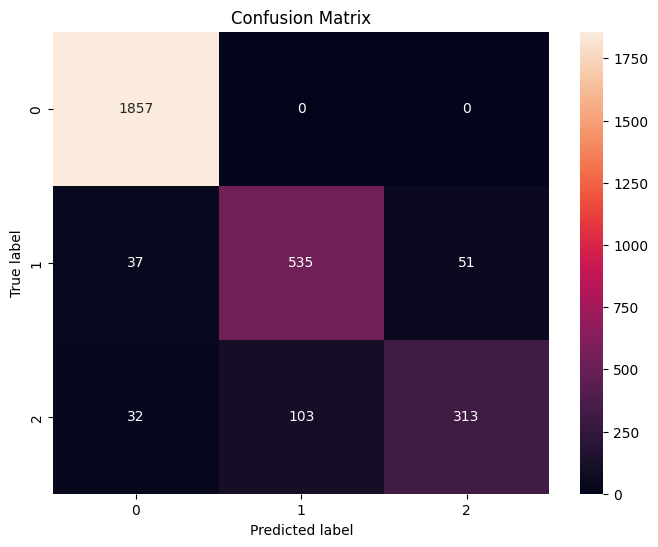

In [42]:
plot_confusion_matrix(y_test, y_predicted_lr)

In [44]:
df_nvda = pd.read_csv('forbes_articles_300.csv')
df_nvda.head()

,Unnamed: 0,Link,Title,Time,Author,Body
0,0,https://www.forbes.com/sites/solrashidi/2025/1...,OpenAI’s Strategic Shift: What The AMD And Nvi...,"Oct 09, 2025, 09:00am EDT",Sol Rashidi,"AMD, Advanced Micro Devices saw a 23.71% surge..."
1,1,https://www.forbes.com/sites/greatspeculations...,Nvidia Stock 2x To $350?,"Oct 07, 2025, 05:30am EDT",Trefis Team,Will Nvidia stock (NASDAQ: NVDA) reach $350 in...
2,2,https://www.forbes.com/sites/devpatnaik/2025/1...,The Lesson from Intel And Nvidia: Choose Actio...,"Oct 06, 2025, 04:42pm EDT",Dev Patnaik,If I told you back in 2010 that a scrappy make...
3,3,https://www.forbes.com/sites/petercohan/2025/0...,"Nvidia Stock Up 1,124%. Other Winners And Whet...","Sep 24, 2025, 01:31pm EDT",Peter Cohan,"Nvidia's $100B investment in OpenAI, linked to..."
4,4,https://www.forbes.com/sites/saibala/2025/09/2...,Nvidia-Powered Diligent Robotics Is Optimizing...,"Sep 23, 2025, 08:30am EDT","Dr. Sai Balasubramanian, M.D., J.D.",With rapid advancements in artificial intellig...


In [45]:
# Use the 'Body' column from df_nvda
for index, row in df_nvda.iterrows():
    text = row['Body']
    t = {'text': [text]} # Wrap the text in a list to match the expected input format
    t = pd.DataFrame(t)
    t_tfidf = tfidf_vectorizer.transform(t.text.tolist())
    out = lr_tfidf.predict(t_tfidf)
    print(f'Sentiment Value for row {index}: {out}')

Sentiment Value for row 0: ['neutral']
Sentiment Value for row 1: ['neutral']
Sentiment Value for row 2: ['negative']
Sentiment Value for row 3: ['neutral']
Sentiment Value for row 4: ['negative']
Sentiment Value for row 5: ['neutral']
Sentiment Value for row 6: ['neutral']
Sentiment Value for row 7: ['neutral']
Sentiment Value for row 8: ['neutral']
Sentiment Value for row 9: ['negative']
Sentiment Value for row 10: ['neutral']
Sentiment Value for row 11: ['neutral']
Sentiment Value for row 12: ['neutral']
Sentiment Value for row 13: ['neutral']
Sentiment Value for row 14: ['neutral']
Sentiment Value for row 15: ['neutral']
Sentiment Value for row 16: ['neutral']
Sentiment Value for row 17: ['neutral']
Sentiment Value for row 18: ['neutral']
Sentiment Value for row 19: ['negative']
Sentiment Value for row 20: ['neutral']
Sentiment Value for row 21: ['neutral']
Sentiment Value for row 22: ['negative']
Sentiment Value for row 23: ['neutral']
Sentiment Value for row 24: ['negative']
Sent